In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Bike .ipynb',
 'sampleSubmission.csv',
 'submission.csv',
 'test.csv',
 'train.csv']

In [3]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train.head()

In [4]:
def time_transform(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
#     df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    
    return df

In [5]:
df_train = time_transform(df_train)

In [ ]:
df_train['weekend'] = df_train['weekday'].apply(lambda x: 1 if (x == 5) | (x == 6) else 0)

In [ ]:
sns.boxplot(df_train['windspeed'])

In [ ]:
fig, ax = plt.subplots(ncols = 2,nrows=1, figsize = (12,15))
n= 1
for i in df_train[['humidity','temp']]:
    plt.subplot(2,1,n)
    n = n+1
    sns.scatterplot(x = df_train[i],y=df_train['count'])


In [ ]:
cols = df_train.columns.difference(['datetime'])
corr = np.corrcoef(df_train[cols].values.T)
fix, ax = plt.subplots(figsize = (10,5))
ax =sns.heatmap(corr, cbar = True, fmt = '.2f', annot=True, cmap = 'OrRd',
               yticklabels = cols, xticklabels = cols)

In [ ]:
cols = df_train.columns.difference(['datetime'])
cols

In [ ]:
df_train.groupby(['season'])[['count']].sum()

In [ ]:
df_train.groupby(['holiday'])['count'].mean()

In [ ]:
df_train['workingday'].value

In [ ]:
fig = plt.subplots(figsize = (10,5))
sns.barplot(x = df_train['workingday'].unique(),y=df_train.groupby(['workingday'])['count'].mean());

In [ ]:
g =sns.FacetGrid(df_train, height = 5)
g.map(sns.barplot, 'holiday', 'count', ci = None, color = np.random.rand(1,3)[0]);

In [ ]:
df_train.columns

In [46]:
features = df_train.drop(columns =['datetime','casual','registered','count'])

In [57]:
target = np.log1p(df_train['count'])

In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import gc

In [10]:
categorical_features = ['season','holiday','workingday','weather']

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}
kf = KFold(n_splits=2)
models = []
for train_index,test_index in kf.split(features):
    
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,
                             categorical_feature=categorical_features, 
                             free_raw_data=False)
    
    d_test = lgb.Dataset(test_features, label=test_target,
                         categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, 
                         valid_sets=[d_training,d_test], 
                         verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()



C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.522697	valid_1's rmse: 0.759424
[50]	training's rmse: 0.293364	valid_1's rmse: 0.642145
[75]	training's rmse: 0.22243	valid_1's rmse: 0.621989
[100]	training's rmse: 0.191468	valid_1's rmse: 0.619711
[125]	training's rmse: 0.173207	valid_1's rmse: 0.620238
Early stopping, best iteration is:
[96]	training's rmse: 0.195425	valid_1's rmse: 0.619396


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.529232	valid_1's rmse: 0.763525
[50]	training's rmse: 0.312257	valid_1's rmse: 0.623705
[75]	training's rmse: 0.243392	valid_1's rmse: 0.590553
[100]	training's rmse: 0.211453	valid_1's rmse: 0.581116
[125]	training's rmse: 0.192632	valid_1's rmse: 0.578219
[150]	training's rmse: 0.177586	valid_1's rmse: 0.577418
[175]	training's rmse: 0.165493	valid_1's rmse: 0.577514
[200]	training's rmse: 0.154633	valid_1's rmse: 0.577704
Early stopping, best iteration is:
[152]	training's rmse: 0.176501	valid_1's rmse: 0.577377


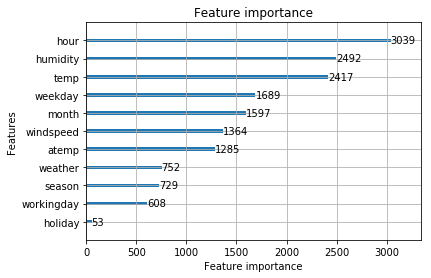

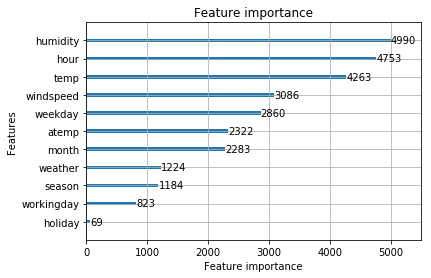

In [11]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [12]:
df_test = pd.read_csv('test.csv')

In [13]:
df_test = time_transform(df_test)

In [14]:
df_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'month', 'hour', 'weekday'],
      dtype='object')

In [15]:
test_combined = df_test.drop(columns=['datetime'])

In [16]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_combined, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_combined, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
results.shape[0]

6493

In [18]:
result_df = pd.DataFrame({'datetime':df_test['datetime'],'count':results})
result_df.to_csv("submission2.csv",index = False)

In [20]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [48]:
X = features
y = target

In [87]:
features

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0000,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,1,4,5
5,1,0,0,2,9.84,12.880,75,6.0032,1,5,5
6,1,0,0,1,9.02,13.635,80,0.0000,1,6,5
7,1,0,0,1,8.20,12.880,86,0.0000,1,7,5
8,1,0,0,1,9.84,14.395,75,0.0000,1,8,5
9,1,0,0,1,13.12,17.425,76,0.0000,1,9,5


In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [60]:
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [64]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [65]:
rf.score(X_test,y_test)

0.8507254574070443

In [68]:
y_pred = rf.predict(X_test)

In [71]:
np.sqrt(mean_squared_log_error(y_test,y_pred))

0.4299890187848692

In [28]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [79]:
score = cross_val_score(rf, X,y,cv=5,scoring='neg_mean_squared_log_error')

In [86]:
np.sqrt(-score)

array([0.84089103, 0.48766694, 0.60311316, 0.47664261, 0.46139511])

In [88]:
y_pred = rf.predict(test_combined)

In [89]:
y_pred.shape

(6493,)

In [91]:
result_df = pd.DataFrame({'datetime':df_test['datetime'],'count':y_pred})
result_df.to_csv("sumb.csv",index= False)

SyntaxError: invalid syntax (<ipython-input-92-f188d5ac1197>, line 1)